In [1]:
import datetime as dt
import json
from loguru import logger
import numpy as np
import pandas as pd
from pathlib import Path
import typing as t
import yfinance as yf

FOLDER = Path(r"C:\Users\tomw1\OneDrive\Desktop")

In [2]:
from quantified_strategies.event_trading import russell_rebalance, super_bowl
from quantified_strategies.overnight_trading import short_term_reversal
from quantified_strategies.seasonal_trading import (
    buy_when_yields_are_low, pay_day_strategy, santa_claus_strategy, september_bear, tax_day_strategy, turn_around_tuesday_strategy)
from quantified_strategies.technical_trading import contrarian_trading

from quantified_strategies import strategy_utils


May need to change to fit other strategy


In [124]:
def get_active_strategies(strategy_map: t.Dict[str, str | t.List[str]], date: dt.date, verbose: bool = True) -> t.Dict[str, t.List[str]]:
    
    strategy_map_list = {strat: universe if isinstance(universe, list) else [universe] for strat, universe in strategy_map.items()}

    active_strats = {strat: [] for strat in strategy_map.keys()}
    
    if (tickers := strategy_map_list.get("russell_rebalance")) and russell_rebalance.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'russell_rebalance' -> {','.join(tickers)}")
        active_strats["russell_rebalance"] += tickers
        
    if (tickers := strategy_map_list.get("super_bowl")) and super_bowl.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'super_bowl' -> {','.join(tickers)}")
        active_strats["super_bowl"] += tickers
        
    if tickers := strategy_map_list.get("short_term_reversal"):
        for ticker in tickers:
            if short_term_reversal.activity.is_active(data=short_term_reversal.utils.fetch(ticker=ticker), date=date):
                if verbose:
                    logger.info(f"Active: 'short_term_reversal' -> {ticker!r}")
                active_strats["short_term_reversal"].append(ticker)
        
    if (tickers := strategy_map_list.get("buy_when_yields_are_low")) and buy_when_yields_are_low.activity.is_active(treasury=buy_when_yields_are_low.utils.fetch_treasury(), date=date, window=15):
        if verbose:
            logger.info(f"Active: 'buy_when_yields_are_low' -> {','.join(tickers)}")
        active_strats["buy_when_yields_are_low"] += tickers
        
    if (tickers := strategy_map_list.get("pay_day_strategy")) and pay_day_strategy.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'pay_day_strategy' -> {','.join(tickers)}")
        active_strats["pay_day_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("sankt_nikolaus_strategy")) and santa_claus_strategy.sankt_nikolaus.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'sankt_nikolaus_strategy' -> {','.join(tickers)}")
        active_strats["sankt_nikolaus_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("santa_claus_strategy")) and santa_claus_strategy.santa_claus.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'santa_claus_strategy' -> {','.join(tickers)}")
        active_strats["santa_claus_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("september_bear")) and september_bear.activity.is_active(data=None, date=date, xday=4, week_enter=3, cover_duration=1):
        if verbose:
            logger.info(f"Active: 'september_bear' -> {','.join(tickers)}")
        active_strats["september_bear"] += tickers
        
    if (tickers := strategy_map_list.get("tax_day_strategy")) and tax_day_strategy.activity.is_active(data=None, date=date, enter_before=dict(month=3, day=31), exit_after=dict(month=4, day=15)):
        if verbose:
            logger.info(f"Active: 'tax_day_strategy' -> {','.join(tickers)}")
        active_strats["tax_day_strategy"] += tickers
        
    if tickers := strategy_map_list.get("turn_around_tuesday_strategy"):
        for ticker in tickers:
            if turn_around_tuesday_strategy.activity.is_active(data=turn_around_tuesday_strategy.utils.fetch(ticker=ticker), date=date):
                if verbose:
                    logger.info(f"Active: 'turn_around_tuesday_strategy' -> {ticker!r}")
                active_strats["turn_around_tuesday_strategy"].append(ticker)

    active_strats = {strat: tickers for strat, tickers in active_strats.items() if len(tickers)}

    return active_strats

def format_active_strats(active_strats: t.Dict[str, t.List[str]]) -> t.Dict[str, t.Any]:

    strategies = list(active_strats.keys())
    assets = sum([tickers for strat, tickers in active_strats.items()], [])

    data = {
        "strategies": strategies,
        "assets": assets,
        "strategy_map": active_strats,
        "sent": False,
    }
    
    return data

# TODO: Save current / desired portfolio
def save(data: t.Dict[str, t.List[str]], filename: str) -> None:

    # the json file where the output must be stored 
    out_file = open(FOLDER / f"{filename}.json", "w") 
    json.dump(data, out_file, indent = 6) 
    out_file.close() 
    
    return

# TODO: Load current / desired portfolio
def load(filename: str) -> t.Dict[str, t.List[str]]:
    with open(FOLDER / f"{filename}.json", "r") as file:
        data = json.load(file)
    return data


def load_historical_strategy_returns() -> pd.DataFrame:
    return pd.read_csv(f"outputs/strategy_returns.csv", header=[0, 1, 2], index_col=0)


def get_sub_historical_strategy_returns(active_strats: t.Dict[str, t.List[str]], hist_returns: pd.DataFrame) -> pd.DataFrame:
    sub_returns = pd.concat([
        hist_returns.loc[:, 
            (hist_returns.columns.get_level_values(1) == strat) 
            & (hist_returns.columns.get_level_values(2).isin(tickers))
        ] for strat, tickers in active_strats.items()], axis=1)
    return sub_returns


def get_last_price(ticker: str) -> float:
    data = yf.download(ticker, interval="1m", progress=False)
    data = data.sort_index(ascending=False)
    data = data.reset_index()
    return data.loc[0, "Close"]

    

In [4]:
def define_portfolio(date: dt.date, store: bool = True, portfolio_value: float = None) -> None:

    # Fetch active strategies
    active_strategies = get_active_strategies(strategy_map=STRATEGY_UNIVERSE_MAP, date=date)
    
    # Load historical strategy returns
    historical_strategy_returns = load_historical_strategy_returns()

    print(active_strategies)
    # Filter out non-active strategies
    sub_returns = get_sub_historical_strategy_returns(active_strats=active_strategies, hist_returns=historical_strategy_returns)
    print(sub_returns)
    # Define side
    sides = pd.Series(sub_returns.columns.get_level_values(1).map(lambda x: STRATEGY_SIDES.get(x, 1)), index=sub_returns.columns)

    # Weights per strategy
    weights = pd.Series(sides / sub_returns.shape[1], index=sub_returns.columns)

    # Sum assets in each strategy
    asset_weights = weights.groupby(level=2).sum()

    # TODO: Fetch real value
    # Ask for current portfolio value
    if portfolio_value is None:
        portfolio_value = float(input("What is the current portfolio value?"))
    
    # Get value to invest in asset
    asset_value = portfolio_value * asset_weights

    # Get most recent price for each asset
    last_prices = pd.Series({asset: get_last_price(ticker=asset) for asset in asset_value.index})

    # TODO: Define price at which to trade -> note using MOC orders
    
    # Define delta
    deltas = (asset_value / last_prices).astype(int)

    # Combine portfolio details
    portfolio_details = pd.concat([
        asset_weights.to_frame(name="weights"), 
        asset_value.to_frame(name="value"), 
        last_prices.to_frame(name="px"), 
        deltas.to_frame(name="delta")
    ], axis=1)
    portfolio_details.index.name = "asset"

    # Combine strategy details
    strategy_details = pd.concat([sides.to_frame(name="side"), weights.to_frame(name="weight")], axis=1)

    if store:
        # Save strategy
        save(data=format_active_strats(active_strats=active_strategies), filename="strategy")
        # Save portfolio
        portfolio_details.to_csv(FOLDER / "portfolio_details.csv")
        # Save strategies
        strategy_details.to_csv(FOLDER / "strategy_details.csv")

    display(portfolio_details)
    display(strategy_details)
    
    return

def get_portfolio() -> pd.DataFrame:
    return pd.read_csv(FOLDER / "expected_portfolio_details.csv", index_col=0)


def reset_portfolio() -> None:
    pd.DataFrame(columns=["asset", "weights", "value", "px", "delta"]).to_csv(FOLDER / "expected_portfolio_details.csv")
    return


## Current Portfolio Calculation

### Define Date

In [5]:
DATE = dt.date.today()
# DATE = dt.date(2024, 2, 23)
date = DATE

### Define Strategy Universe

In [6]:
US_INDICES = ["SPY", "QQQ"]

STRATEGY_UNIVERSE_MAP = {
    "russell_rebalance": "IWM",
    "super_bowl": US_INDICES,
    "short_term_reversal": US_INDICES,
    "buy_when_yields_are_low": US_INDICES,
    "pay_day_strategy": US_INDICES,
    "sankt_nikolaus_strategy": "EWG",
    "santa_claus_strategy": US_INDICES,
    "september_bear": US_INDICES,
    "tax_day_strategy": US_INDICES,
    "turn_around_tuesday_strategy": US_INDICES,
}
STRATEGY_UNIVERSE_MAP

{'russell_rebalance': 'IWM',
 'super_bowl': ['SPY', 'QQQ'],
 'short_term_reversal': ['SPY', 'QQQ'],
 'buy_when_yields_are_low': ['SPY', 'QQQ'],
 'pay_day_strategy': ['SPY', 'QQQ'],
 'sankt_nikolaus_strategy': 'EWG',
 'santa_claus_strategy': ['SPY', 'QQQ'],
 'september_bear': ['SPY', 'QQQ'],
 'tax_day_strategy': ['SPY', 'QQQ'],
 'turn_around_tuesday_strategy': ['SPY', 'QQQ']}

In [7]:
STRATEGY_SIDES = {
    "september_bear": -1,
}
STRATEGY_SIDES

{'september_bear': -1}

## Define Current Portfolio

In [8]:
# reset_portfolio()

In [9]:
define_portfolio(date=DATE, store=False, portfolio_value=500.0)

2024-02-26 09:26:12.443 | INFO     | __main__:get_active_strategies:26 - Active: 'pay_day_strategy' -> SPY,QQQ


{'pay_day_strategy': ['SPY', 'QQQ']}
           seasonal_trading          
           pay_day_strategy          
                        SPY       QQQ
Date                                 
2000-01-03        -0.039107 -0.068601
2000-01-04              NaN       NaN
2000-01-05              NaN       NaN
2000-01-06              NaN       NaN
2000-01-07              NaN       NaN
...                     ...       ...
2024-02-15              NaN       NaN
2024-02-16              NaN       NaN
2024-02-20              NaN       NaN
2024-02-21              NaN       NaN
2024-02-22              NaN       NaN

[6073 rows x 2 columns]


,weights,value,px,delta
asset,,,,
QQQ,0.5,250.0,436.739990,0
SPY,0.5,250.0,507.820007,0


side  weight
seasonal_trading pay_day_strategy SPY     1     0.5
                                  QQQ     1     0.5

## Fetch Expected Portfolio

In [8]:
expected_portfolio = get_portfolio()
expected_portfolio

,weights,value,px,delta
asset,,,,
SPY,1.0,500.0,499.48999,1


In [9]:
COLUMNS = [
    ('event_trading', 'super_bowl', 'SPY'),
    ('event_trading', 'super_bowl', 'QQQ'),
    ('overnight_trading', 'short_term_reversal', 'SPY'),
    ('overnight_trading', 'short_term_reversal', 'QQQ'),
    ('seasonal_trading', 'buy_when_yields_are_low', 'SPY'),
    ('seasonal_trading', 'buy_when_yields_are_low', 'QQQ'),
    ('seasonal_trading', 'pay_day_strategy', 'SPY'),
    ('seasonal_trading', 'pay_day_strategy', 'QQQ'),
    ('seasonal_trading', 'santa_claus_strategy', 'SPY'),
    ('seasonal_trading', 'santa_claus_strategy', 'QQQ'),
    ('seasonal_trading', 'september_bear', 'SPY'),
    ('seasonal_trading', 'september_bear', 'QQQ'),
    ('seasonal_trading', 'tax_day_strategy', 'SPY'),
    ('seasonal_trading', 'tax_day_strategy', 'QQQ'),
    ('seasonal_trading', 'turn_around_tuesday_strategy', 'SPY'),
    ('seasonal_trading', 'turn_around_tuesday_strategy', 'QQQ'),
    'hold_days',
    'pos_SPY',
    'pos_QQQ',
    'pos_CASH'
]
COLUMNS

[('event_trading', 'super_bowl', 'SPY'),
 ('event_trading', 'super_bowl', 'QQQ'),
 ('overnight_trading', 'short_term_reversal', 'SPY'),
 ('overnight_trading', 'short_term_reversal', 'QQQ'),
 ('seasonal_trading', 'buy_when_yields_are_low', 'SPY'),
 ('seasonal_trading', 'buy_when_yields_are_low', 'QQQ'),
 ('seasonal_trading', 'pay_day_strategy', 'SPY'),
 ('seasonal_trading', 'pay_day_strategy', 'QQQ'),
 ('seasonal_trading', 'santa_claus_strategy', 'SPY'),
 ('seasonal_trading', 'santa_claus_strategy', 'QQQ'),
 ('seasonal_trading', 'september_bear', 'SPY'),
 ('seasonal_trading', 'september_bear', 'QQQ'),
 ('seasonal_trading', 'tax_day_strategy', 'SPY'),
 ('seasonal_trading', 'tax_day_strategy', 'QQQ'),
 ('seasonal_trading', 'turn_around_tuesday_strategy', 'SPY'),
 ('seasonal_trading', 'turn_around_tuesday_strategy', 'QQQ'),
 'hold_days',
 'pos_SPY',
 'pos_QQQ',
 'pos_CASH']

In [125]:
import torch
from quantified_strategies.models import Net_Asset_Allocator_with_Position_Management as Net

def convert_data(strats, expected_port):
    X = pd.Series(0.0, index=COLUMNS)
    for index in COLUMNS:
        if isinstance(index, str):
            if index == "hold_days":
                print("hold_days")
                continue
            else:
                _, asset = index.split("_", maxsplit=1)
                
                if asset not in expected_port.index:
                    continue
                X[index] = expected_port.loc[asset, "weights"]
                continue
        else:
            _, strat_name, asset = index
            if assets := strats.get(strat_name):
                if asset in assets:
                    X[index] = 1.0
    X = X.to_frame(name="current_portfolio").T
    return X

def get_portfolio(date: dt.date, expected_port = None):

    if expected_port is None:
        expected_port = pd.Series(0, index=["SPY", "QQQ", "CASH"]).to_frame(name="weights")
    
    model = Net.load(input_shape=len(COLUMNS), output_shape=3, name="latest")
    active_strategies = get_active_strategies(strategy_map=STRATEGY_UNIVERSE_MAP, date=date, verbose=True)
    X = convert_data(strats=active_strategies, expected_port=expected_port)
    X = torch.Tensor(X.values)

    expected_port = pd.Series(model(X).reshape(3).detach().numpy(), index=["SPY", "QQQ", "CASH"])
    expected_port = expected_port.to_frame(name="weights")

    return expected_port


In [126]:
expected_portfolio = None
expected_portfolios = []
for date in pd.date_range(start=dt.date(2024, 1, 1), end=dt.date.today(), freq="B"):
    expected_portfolio = get_portfolio(date=date.date(), expected_port=expected_portfolio)
    expected_portfolios.append(expected_portfolio.rename(columns={"weights": date}))

    print(date)
    print(expected_portfolio.round(3))
    
expected_portfolios = pd.concat(expected_portfolios, axis=1).T
expected_portfolios

2024-02-27 16:05:52.086 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ
2024-02-27 16:05:52.087 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ
2024-02-27 16:05:52.556 | INFO     | __main__:get_active_strategies:41 - Active: 'santa_claus_strategy' -> SPY,QQQ


hold_days
2024-01-01 00:00:00
           weights
SPY   1.695752e-05
QQQ   2.980232e-08
CASH  9.999831e-01


2024-02-27 16:05:54.457 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'QQQ'
2024-02-27 16:05:56.798 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ
2024-02-27 16:05:56.905 | INFO     | __main__:get_active_strategies:41 - Active: 'santa_claus_strategy' -> SPY,QQQ


hold_days
2024-01-02 00:00:00
           weights
SPY   4.678965e-06
QQQ   9.999946e-01
CASH  6.556511e-07


2024-02-27 16:05:58.878 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'SPY'
2024-02-27 16:05:59.254 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'QQQ'
2024-02-27 16:06:01.687 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ
2024-02-27 16:06:01.796 | INFO     | __main__:get_active_strategies:41 - Active: 'santa_claus_strategy' -> SPY,QQQ


hold_days
2024-01-03 00:00:00
      weights
SPY       0.0
QQQ       1.0
CASH      0.0


2024-02-27 16:06:03.905 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'SPY'
2024-02-27 16:06:04.238 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'QQQ'
2024-02-27 16:06:06.288 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ


hold_days
2024-01-04 00:00:00
           weights
SPY   8.940697e-08
QQQ   9.999999e-01
CASH  2.980232e-08


2024-02-27 16:06:10.600 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ


hold_days
2024-01-05 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:06:15.430 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ


hold_days
2024-01-08 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-09 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-10 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-11 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-12 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-15 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-16 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-17 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-18 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-19 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-22 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-01-23 00:00:00
      weights
SPY       

2024-02-27 16:07:19.600 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-01-25 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:24.645 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-01-26 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:29.450 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-01-29 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:34.711 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-01-30 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:39.108 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-01-31 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:44.415 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-02-01 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:49.208 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ


hold_days
2024-02-02 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:07:53.995 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ
2024-02-27 16:07:54.409 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:07:54.750 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-05 00:00:00
           weights
SPY   3.308058e-06
QQQ   2.980232e-08
CASH  9.999967e-01


2024-02-27 16:07:58.993 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ
2024-02-27 16:07:59.362 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:07:59.787 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-06 00:00:00
           weights
SPY   3.308058e-06
QQQ   2.980232e-08
CASH  9.999967e-01


2024-02-27 16:08:04.095 | INFO     | __main__:get_active_strategies:26 - Active: 'buy_when_yields_are_low' -> SPY,QQQ


hold_days
2024-02-07 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-02-08 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0
hold_days
2024-02-09 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:08:15.306 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ
2024-02-27 16:08:18.833 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:08:19.269 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-12 00:00:00
       weights
SPY   0.000554
QQQ   0.997890
CASH  0.001556


2024-02-27 16:08:19.999 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ
2024-02-27 16:08:23.444 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:08:23.916 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-13 00:00:00
       weights
SPY   0.003386
QQQ   0.977732
CASH  0.018882


2024-02-27 16:08:24.668 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-14 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:08:29.822 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-15 00:00:00
           weights
SPY   2.980232e-08
QQQ   0.000000e+00
CASH  1.000000e+00


2024-02-27 16:08:34.228 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-16 00:00:00
           weights
SPY   2.980232e-08
QQQ   0.000000e+00
CASH  1.000000e+00


2024-02-27 16:08:39.067 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-19 00:00:00
           weights
SPY   2.980232e-08
QQQ   0.000000e+00
CASH  1.000000e+00


2024-02-27 16:08:43.711 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-20 00:00:00
           weights
SPY   2.980232e-08
QQQ   0.000000e+00
CASH  1.000000e+00


2024-02-27 16:08:48.895 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ
2024-02-27 16:08:50.088 | INFO     | __main__:get_active_strategies:21 - Active: 'short_term_reversal' -> 'QQQ'


hold_days
2024-02-21 00:00:00
           weights
SPY   1.549721e-06
QQQ   9.999982e-01
CASH  2.384186e-07


2024-02-27 16:08:53.861 | INFO     | __main__:get_active_strategies:14 - Active: 'super_bowl' -> SPY,QQQ


hold_days
2024-02-22 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:09:01.666 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ


hold_days
2024-02-23 00:00:00
      weights
SPY       0.0
QQQ       0.0
CASH      1.0


2024-02-27 16:09:06.827 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ
2024-02-27 16:09:07.222 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:09:07.537 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-26 00:00:00
       weights
SPY   0.007716
QQQ   0.154696
CASH  0.837588


2024-02-27 16:09:11.370 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ
2024-02-27 16:09:11.752 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:09:12.116 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days
2024-02-27 00:00:00
       weights
SPY   0.006607
QQQ   0.087521
CASH  0.905871


,SPY,QQQ,CASH
2024-01-01,1.695752e-05,2.980232e-08,9.999831e-01
2024-01-02,4.678965e-06,9.999946e-01,6.556511e-07
2024-01-03,0.000000e+00,1.000000e+00,0.000000e+00
2024-01-04,8.940697e-08,9.999999e-01,2.980232e-08
2024-01-05,0.000000e+00,0.000000e+00,1.000000e+00
2024-01-08,0.000000e+00,0.000000e+00,1.000000e+00
2024-01-09,0.000000e+00,0.000000e+00,1.000000e+00
2024-01-10,0.000000e+00,0.000000e+00,1.000000e+00
2024-01-11,0.000000e+00,0.000000e+00,1.000000e+00
2024-01-12,0.000000e+00,0.000000e+00,1.000000e+00


<Axes: >

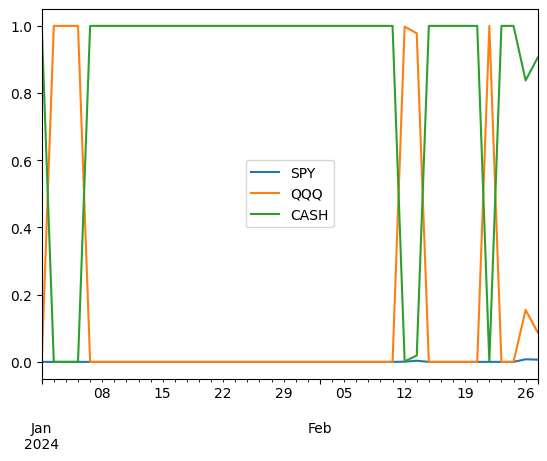

In [127]:
expected_portfolios.plot()

In [128]:
get_portfolio(date=dt.date.today(), expected_port=None)

2024-02-27 16:10:21.157 | INFO     | __main__:get_active_strategies:31 - Active: 'pay_day_strategy' -> SPY,QQQ
2024-02-27 16:10:21.493 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'SPY'
2024-02-27 16:10:21.779 | INFO     | __main__:get_active_strategies:58 - Active: 'turn_around_tuesday_strategy' -> 'QQQ'


hold_days


,weights
SPY,0.000427
QQQ,0.999193
CASH,0.000380
